In [167]:
# работа с ОС
import warnings
from google.colab import drive
# работа с данными
import numpy as np
import pandas as pd
# работа с ML
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# визуализация
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


drive.mount("/content/drive")
pd.options.display.max_rows = 93
pd.options.display.max_columns = 93
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"
!pip install pyarrow

geopandas==0.13.2
lightgbm==4.1.0
numpy==1.25.2
pandas==2.0.3
pandas-datareader==0.10.0
pandas-gbq==0.19.2
pandas-stubs==2.0.3.230814
scikit-learn==1.2.2
sklearn-pandas==2.2.0


## Подготовка данных

In [142]:
train_df = pd.read_parquet("/content/drive/MyDrive/train_data.pqt", engine='auto')
test_df = pd.read_parquet("/content/drive/MyDrive/test_data.pqt")

In [57]:
train_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,ogrn_month,ogrn_year,ft_registration_date,max_founderpres,min_founderpres,ogrn_exist_months,okved,segment,sum_of_paym_2m,sum_of_paym_6m,sum_of_paym_1y,sum_a_oper_1m,cnt_a_oper_1m,sum_b_oper_1m,cnt_b_oper_1m,sum_c_oper_1m,cnt_c_oper_1m,sum_deb_d_oper_1m,cnt_deb_d_oper_1m,sum_cred_d_oper_1m,cnt_cred_d_oper_1m,sum_deb_e_oper_1m,cnt_deb_e_oper_1m,cnt_days_deb_e_oper_1m,sum_cred_e_oper_1m,cnt_cred_e_oper_1m,cnt_days_cred_e_oper_1m,sum_deb_f_oper_1m,cnt_deb_f_oper_1m,cnt_days_deb_f_oper_1m,sum_cred_f_oper_1m,cnt_cred_f_oper_1m,cnt_days_cred_f_oper_1m,sum_deb_g_oper_1m,cnt_deb_g_oper_1m,cnt_days_deb_g_oper_1m,sum_cred_g_oper_1m,cnt_cred_g_oper_1m,cnt_days_cred_g_oper_1m,sum_deb_h_oper_1m,cnt_deb_h_oper_1m,cnt_days_deb_h_oper_1m,sum_cred_h_oper_1m,cnt_cred_h_oper_1m,cnt_days_cred_h_oper_1m,sum_a_oper_3m,cnt_a_oper_3m,sum_b_oper_3m,cnt_b_oper_3m,sum_c_oper_3m,cnt_c_oper_3m,sum_deb_d_oper_3m,cnt_deb_d_oper_3m,sum_cred_d_oper_3m,cnt_cred_d_oper_3m,sum_deb_e_oper_3m,cnt_deb_e_oper_3m,cnt_days_deb_e_oper_3m,sum_cred_e_oper_3m,cnt_cred_e_oper_3m,cnt_days_cred_e_oper_3m,sum_deb_f_oper_3m,cnt_deb_f_oper_3m,cnt_days_deb_f_oper_3m,sum_cred_f_oper_3m,cnt_cred_f_oper_3m,cnt_days_cred_f_oper_3m,sum_deb_g_oper_3m,cnt_deb_g_oper_3m,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,ogrn_month_0,ogrn_year_1,2.452182,2.736461,2.932560,2.437979,okved_30,segment_1,0.942275,0.536013,0.511490,-0.188835,0.417022,-0.030225,0.435995,-0.103359,0.550798,-0.128513,0.967030,-0.063678,0.221993,0.396523,0.893064,0.463405,0.505823,0.873795,0.623277,-0.125219,0.771335,0.212528,-0.017983,0.154163,0.777702,-0.041418,0.513943,0.848818,0.099899,0.226247,0.391439,1.054211,0.654057,0.387856,1.171020,0.648942,0.661628,-0.207082,0.208461,-0.029964,0.517298,-0.119654,0.960017,-0.143207,0.870124,-0.084701,0.307935,0.356556,0.426034,1.201541,0.435983,0.864246,1.270517,-0.152107,0.286074,0.891856,-0.025646,0.24851,0.038562,-0.040649,0.458055,0.728507,0.186820,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,ogrn_month_0,ogrn_year_1,2.469917,2.756014,2.952725,2.455375,okved_30,segment_1,0.645704,0.536378,0.486425,-0.188835,0.417022,-0.030225,0.435995,-0.103359,0.550798,-0.088209,0.969891,-0.063678,0.221993,0.131636,0.893042,0.398889,0.095082,0.873685,0.526503,-0.101797,0.771350,0.244786,-0.017983,0.154163,0.777702,-0.041418,0.513943,0.848818,-0.021465,0.224276,0.326923,0.419979,0.652830,0.258824,0.410410,0.633498,0.564854,-0.207082,0.208461,-0.029964,0.517298,-0.119654,0.960017,-0.127755,0.870983,-0.084701,0.307935,0.302226,0.425993,1.135607,0.411205,0.864251,1.237550,-0.142187,0.286081,0.902845,-0.025646,0.24851,0.038562,-0.040649,0.458055,0.728507,0.125043,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,ogrn_month_0,ogrn_year_1,2.485936,2.773674,2.970940,2.472771,okved_30,segment_1,0.403604,0.613167,0.480547,-0.188835,0.417022,-0.030225,0.435995,-0.103359,0.550798,-0.128513,0.967030,-0.063678,0.221993,0.485924,0.893049,0.560179,0.148894,0.873656,0.623277,-0.125219,0.771335,0.212528,-0.017983,0.154163,0.777702,-0.041418,0.513943,0.848818,-0.029795,0.223291,0.294665,1.251369,0.653444,0.387856,0.552757,0.629637,0.661628,-0.207082,0.208461,-0.029964,0.517298,-0.119654,0.960017,-0.127755,0.870983,-0.084701

In [58]:
test_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,ogrn_month,ogrn_year,ft_registration_date,max_founderpres,min_founderpres,ogrn_exist_months,okved,segment,sum_of_paym_2m,sum_of_paym_6m,sum_of_paym_1y,sum_a_oper_1m,cnt_a_oper_1m,sum_b_oper_1m,cnt_b_oper_1m,sum_c_oper_1m,cnt_c_oper_1m,sum_deb_d_oper_1m,cnt_deb_d_oper_1m,sum_cred_d_oper_1m,cnt_cred_d_oper_1m,sum_deb_e_oper_1m,cnt_deb_e_oper_1m,cnt_days_deb_e_oper_1m,sum_cred_e_oper_1m,cnt_cred_e_oper_1m,cnt_days_cred_e_oper_1m,sum_deb_f_oper_1m,cnt_deb_f_oper_1m,cnt_days_deb_f_oper_1m,sum_cred_f_oper_1m,cnt_cred_f_oper_1m,cnt_days_cred_f_oper_1m,sum_deb_g_oper_1m,cnt_deb_g_oper_1m,cnt_days_deb_g_oper_1m,sum_cred_g_oper_1m,cnt_cred_g_oper_1m,cnt_days_cred_g_oper_1m,sum_deb_h_oper_1m,cnt_deb_h_oper_1m,cnt_days_deb_h_oper_1m,sum_cred_h_oper_1m,cnt_cred_h_oper_1m,cnt_days_cred_h_oper_1m,sum_a_oper_3m,cnt_a_oper_3m,sum_b_oper_3m,cnt_b_oper_3m,sum_c_oper_3m,cnt_c_oper_3m,sum_deb_d_oper_3m,cnt_deb_d_oper_3m,sum_cred_d_oper_3m,cnt_cred_d_oper_3m,sum_deb_e_oper_3m,cnt_deb_e_oper_3m,cnt_days_deb_e_oper_3m,sum_cred_e_oper_3m,cnt_cred_e_oper_3m,cnt_days_cred_e_oper_3m,sum_deb_f_oper_3m,cnt_deb_f_oper_3m,cnt_days_deb_f_oper_3m,sum_cred_f_oper_3m,cnt_cred_f_oper_3m,cnt_days_cred_f_oper_3m,sum_deb_g_oper_3m,cnt_deb_g_oper_3m,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,None,-1.533705,-1.683741,ogrn_month_8,ogrn_year_11,-0.653810,NaN,NaN,-0.658497,okved_0,segment_3,0.416833,0.332409,0.676573,0.532156,0.421695,-0.030225,0.435995,1.123507,0.552726,-0.128513,0.96703,-0.063678,0.221993,0.278159,0.893289,0.818244,0.266375,0.873550,0.526503,4.591710,0.771350,0.244786,-0.017983,0.154163,0.777702,-0.034588,0.515230,0.913334,0.078352,0.226247,0.326923,-0.144097,0.652523,0.291082,0.413722,0.605505,0.500338,0.957934,0.214730,-0.029964,0.517298,1.660281,0.963300,-0.143207,0.870124,-0.055135,0.309193,0.175471,0.426448,1.366376,0.143413,0.863866,0.951836,3.136945,0.286081,0.902845,-0.025646,0.24851,0.038562,0.026364,0.460730,0.849386,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,None,-1.533705,-1.683741,ogrn_month_8,ogrn_year_11,-0.636647,NaN,NaN,-0.641101,okved_0,segment_3,0.433195,0.284317,0.688449,-0.069498,0.421695,-0.030225,0.435995,4.983369,0.556064,-0.128513,0.96703,0.089395,0.223973,0.119735,0.893536,0.850502,0.131938,0.873598,0.526503,1.399146,0.771350,0.244786,-0.017983,0.154163,0.777702,-0.010645,0.514586,0.881076,-0.029795,0.223291,0.294665,-0.145537,0.652216,0.194308,0.363179,0.612262,0.532596,1.002756,0.216298,-0.029964,0.517298,3.022775,0.963687,-0.143207,0.870124,-0.008083,0.309193,0.195415,0.426482,1.410332,0.189248,0.863929,1.061726,3.136964,0.286088,0.913834,-0.025646,0.24851,0.038562,0.003038,0.459615,0.805430,0.006812,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α}
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,None,-1.533705,-1.683741,ogrn_month_8,ogrn_year_11,-0.618911,NaN,NaN,-0.623705,okved_0,segment_3,0.223961,0.285376,0.671862,2.698111,0.431041,-0.030225,0.435995,4.186482,0.557473,-0.128513,0.96703,-0.063678,0.221993,-0.002000,0.893674,0.753728,0.090933,0.873559,0.526503,-0.173564,0.771321,0.180270,-0.017983,0.154163,0.777702,0.000068,0.515230,0.913334,-0.029795,0.223291,0.294665,-0.150212,0.651909,0.194308,0.219106,0.605505,0.468080,1.182043,0.216298,-0.029964,0.517298,4.162265,0.965149,-0.143207,0.870124,-0.014715,0.308564,0.149694,0.426615,1.465277,0.185240,0.863974,1.171616,2.470867,0.286081,0.902845,-0.

### Предобработка численных признаков

Корреляция признаков

In [162]:
num_type_corr_train = train_df.select_dtypes(include='number').corr().abs()

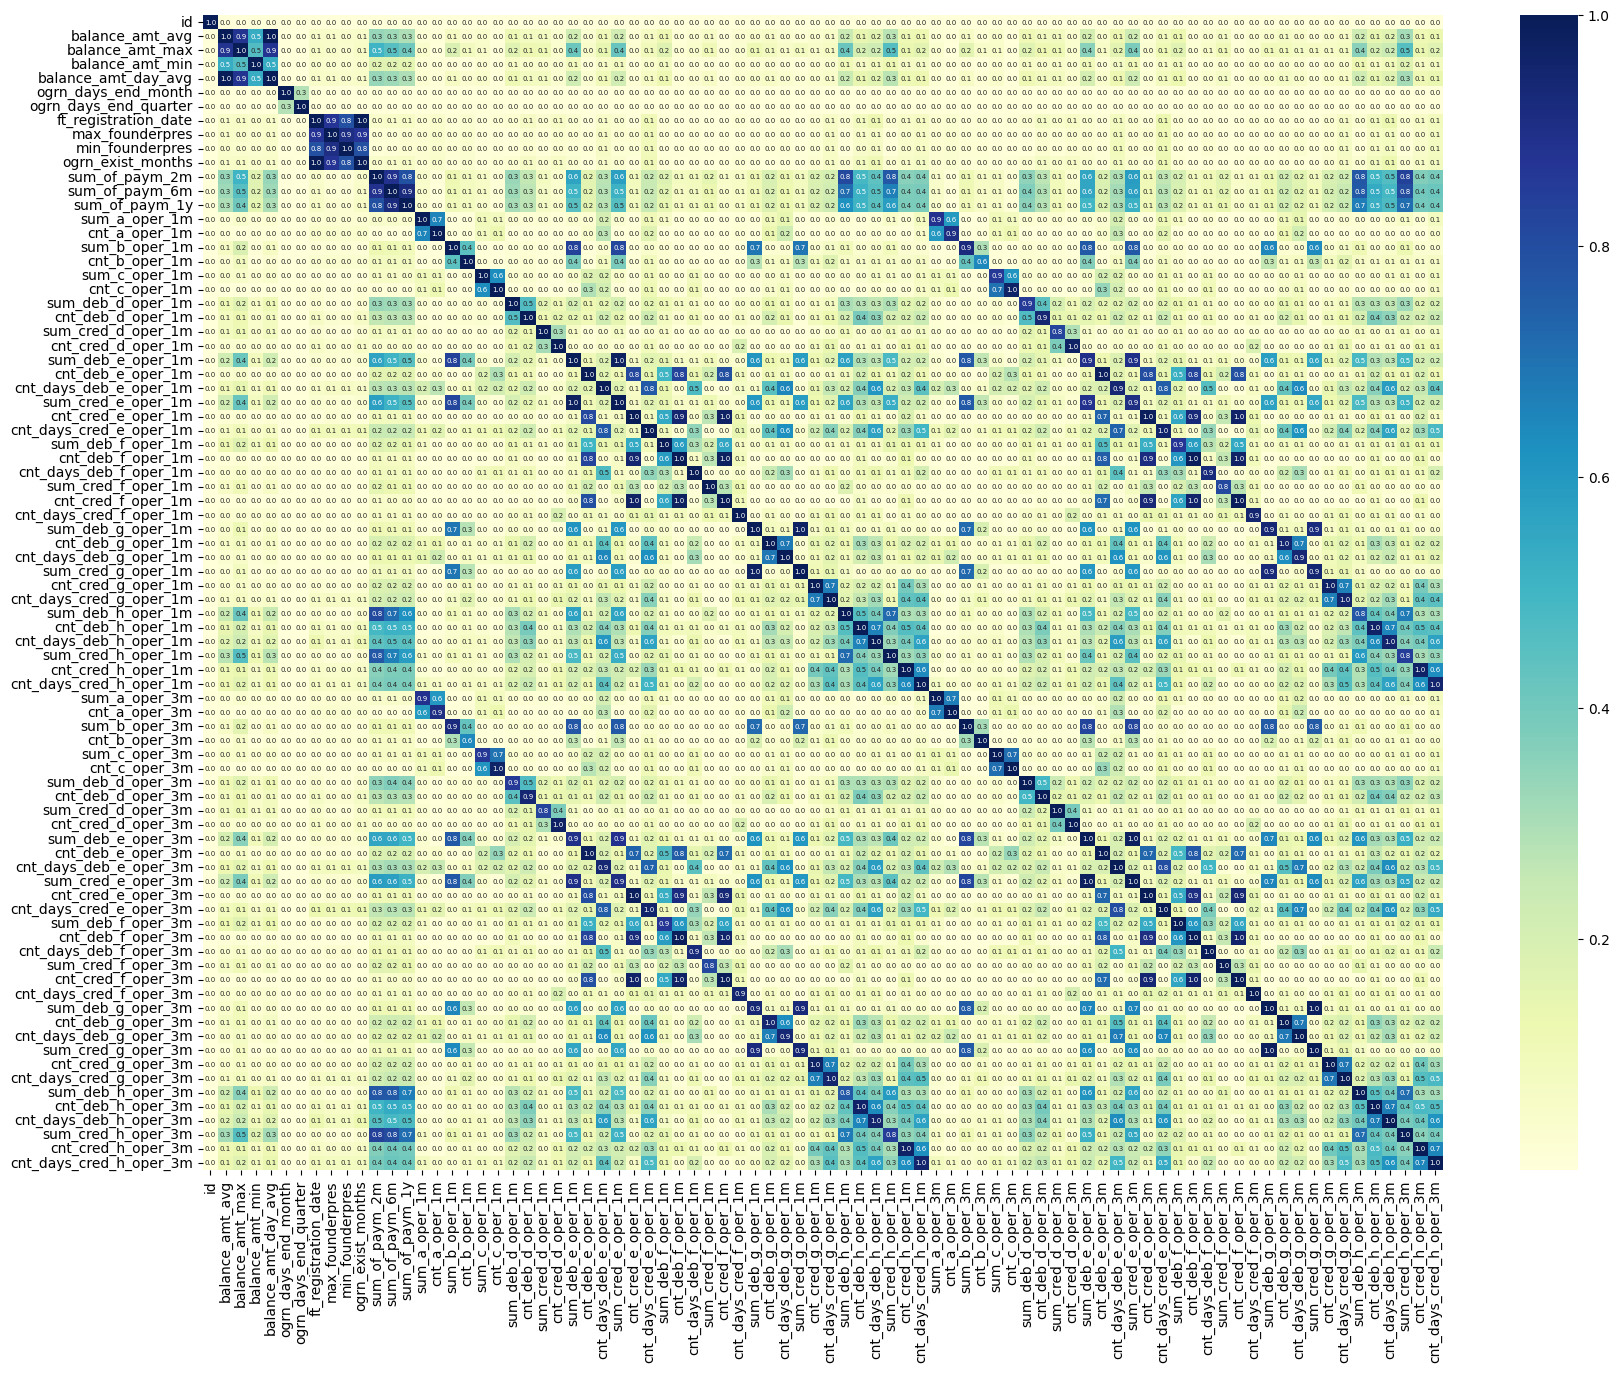

In [163]:
figure(figsize=(20, 15))
dataplot = sns.heatmap(num_type_corr_train,
                      cmap="YlGnBu", annot=True, fmt=".1f",
                      annot_kws={'size': 5})
plt.show()

### Предобработка категориальных признаков


In [59]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "date",
    "index_city_code", "ogrn_month", "ogrn_year",
]

In [60]:
train_cat = train_df[cat_cols]
train_cat.head(3)

,channel_code,city,city_type,okved,segment,date,index_city_code,ogrn_month,ogrn_year
0,channel_code_5,city_23,city_type_0,okved_30,segment_1,month_1,index_city_code_39,ogrn_month_0,ogrn_year_1
1,channel_code_5,city_23,city_type_0,okved_30,segment_1,month_2,index_city_code_39,ogrn_month_0,ogrn_year_1
2,channel_code_5,city_23,city_type_0,okved_30,segment_1,month_3,index_city_code_39,ogrn_month_0,ogrn_year_1


In [131]:
label_encoders = {}

for col in cat_cols:
    label_encoders[col] = LabelEncoder()
    train_cat[col] = label_encoders[col].fit_transform(train_cat[col])
    train_df[col] = label_encoders[col].fit_transform(train_df[col])
    test_df[col] = label_encoders[col].fit_transform(test_df[col])
train_cat.head(3)

,channel_code,city,city_type,okved,segment,date,index_city_code,ogrn_month,ogrn_year
0,40,1446,0,24,1,0,166,0,1
1,40,1446,0,24,1,1,166,0,1
2,40,1446,0,24,1,2,166,0,1


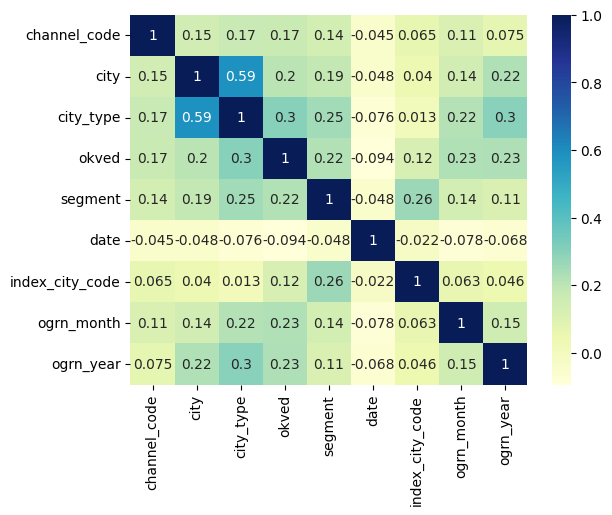

In [51]:
dataplot = sb.heatmap(train_cat.corr(), cmap="YlGnBu", annot=True)
plt.show()

### Предобработка признака start_cluster

In [125]:
test_df['start_cluster'].unique()

array(['{α}', None, '{other}', '{}', '{α, μ}', '{α, γ}', '{α, β}',
       '{α, ε, η}', '{α, η}', '{α, δ}', '{α, ε}', '{α, ψ}', '{α, θ}',
       '{α, λ}', '{α, ε, θ}', '{λ}', '{α, ε, ψ}', '{α, π}'], dtype=object)

In [65]:
start_cluster = train_df['start_cluster']
start_cluster.unique()

array(['{α, γ}', '{other}', '{α}', '{}', '{α, ε, ψ}', '{α, δ}', '{α, η}',
       '{α, β}', '{α, ε, η}', '{α, μ}', '{α, ψ}', '{α, λ}', '{α, ε}',
       '{α, ε, θ}', '{α, θ}', '{λ}', '{α, π}'], dtype=object)

In [126]:
spec_vals = ['α', 'β', 'γ', 'ε', 'ψ', 'δ', 'η', 'μ', 'λ', 'θ', 'π',
             'other', 'empty', 'None']

In [129]:
train_df['start_cluster'] = train_df['start_cluster'].str.strip('{}')
test_df['start_cluster'] = test_df['start_cluster'].str.strip('{}')
test_df['start_cluster'].fillna('None', inplace=True)
for col in spec_vals:
    train_df[f'start_cluster_{col}'] = 0
    train_df[f'start_cluster_{col}'] = train_df['start_cluster'].apply(lambda x: 1 if col in x else 0)
    test_df[f'start_cluster_{col}'] = 0
    test_df[f'start_cluster_{col}'] = test_df['start_cluster'].apply(lambda x: 1 if col in x else 0)
train_df['start_cluster_empty'] = train_df['start_cluster'].apply(lambda x: 1 if '{}' in x else 0)
test_df['start_cluster_empty'] = test_df['start_cluster'].apply(lambda x: 1 if '{}' in x else 0)
train_df = train_df.drop(columns=['start_cluster'])
test_df = test_df.drop(columns=['start_cluster'])

Создаем выборки для валидации и обучения

In [ ]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

## Обучение модели

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [ ]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

Зададим функцию для взвешенной метрики roc auc

In [139]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [ ]:
cluster_weights = pd.read_excel("/content/drive/MyDrive/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

## Прогноз на тестовой выборке